In [2]:
%load_ext autoreload

%autoreload 2

In [55]:
import os

import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold

from torch.utils.data import Dataset, DataLoader, ConcatDataset


In [149]:
class ConcatenatedDataset(Dataset):
    def __init__(
        self, annotations_file, img_dir, transform_positives=None, transform_backgroun=None, target_transform=None
    ):
        self.img_labels = pd.read_csv(annotations_file, header=None)
        self.img_dir = img_dir
        self.transform_positives = transform_positives  # TODO
        self.transform_backgroun = transform_backgroun # TODO
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = np.array(Image.open(img_path).convert("L"))
        label = self.img_labels.iloc[idx, 1]
        # if self.transform:
        #     image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [150]:
class CustomImageDataset(Dataset):
    def __init__(
        self, annotations_file, img_dir, transform=None, target_transform=None
    ):
        self.img_labels = pd.read_csv(annotations_file, header=None)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = np.array(Image.open(img_path).convert("L"))
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [129]:
dataset_positives = CustomImageDataset(annotations_file="imgs_rect/positives_labels.csv", img_dir="imgs_rect")
dataset_background = CustomImageDataset(annotations_file="imgs_raw/labels.csv", img_dir="imgs_raw") # TODO transform=random_crop equals positives
dataset = ConcatDataset([dataset_positives, dataset_background])

dataloader = DataLoader(dataset_positives, batch_size=10)

(224, 224)


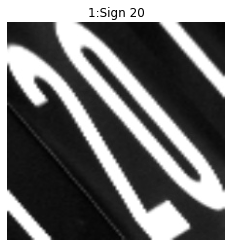

In [119]:
labels_map = {0: "Background", 1:"Sign 20", 2:"Sign 30"}
img, label = dataset[0]
print(img.shape)
plt.title('{}:{}'.format(label,labels_map[label]))
plt.axis("off")
plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [151]:
whole_dataset = ConcatenatedDataset(annotations_file="imgs_merged/labels.csv", img_dir="imgs_merged")

In [152]:
whole_dataset[0]

AttributeError: 'ConcatenatedDataset' object has no attribute 'transform'

In [137]:
df1 = dataset_positives.img_labels
df2 = dataset_background.img_labels

dataset_filename_label = pd.concat([df1, df2])
dataset_filename_label[0]

0     c48f27f02f5f1812.jpg
1     69f3efa468d0004f.jpg
2     69f3efa468d8025f.jpg
3     448f27f0af5f1812.jpg
4     448fa7f0af7f1052.jpg
              ...         
49               img15.jpg
50              img260.jpg
51               img10.jpg
52              img115.jpg
53              img100.jpg
Name: 0, Length: 119, dtype: object

In [53]:
splitter = StratifiedKFold(n_splits=4, shuffle=True, random_state=0)

splits = []
for train_idx, test_idx in splitter.split():
    splits.append((train_idx, test_idx))

2
1
1
2
2
2
1
1
2
3
1
3
3
3
1
3
3
1
1
2
2
1
3
3
1
3
1
3
1
3
1
2
2
3
2
1
1
1
3
1
3
2
1
3
1
1
2
1
2
2
1
3
3
2
2
1
3
1
1
3
1
1
2
2
1
1
2
3
3
3
2
3
2
3
1
1
3
1
1
2
3
3
1
3
1
2
1
2
3
3
3
1
2
3
3
2
2
3
3
3
3
1
